In [ ]:
!pip install kornia

     |████████████████████████████████| 225kB 15.7MB/s 


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import kornia
import scipy

epsilons = [.3]
#epsilons = [0.3] 
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

In [ ]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    #Defines the iterations, one iteration is a FGSM, more than one would be a PGD
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    Adv_correct = 0
    adv_examples = []

    Fix_correct = 0
    Fix_examples = []

    #Adjust to change the FGSM to a PGD. A Value of one would be a FGSM attack, while >1 is a PGD attack.
    PGD_ATTACK = 20

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        
        for i in range(PGD_ATTACK):
          # Set requires_grad attribute of tensor. Important for Attack
          data.requires_grad = True

          # Forward pass the data through the model
          output = model(data)
          init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

          # If the initial prediction is wrong, dont bother attacking, just move on
          if init_pred.item() != target.item():
              continue


          # Calculate the loss
          loss = F.nll_loss(output, target)

          # Zero all existing gradients
          model.zero_grad()

          # Calculate gradients of model in backward pass
          loss.backward()

          # Collect datagrad
          data_grad = data.grad.data

          # Call FGSM Attack
          perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            Adv_correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

        ##########################
        # Attempt to fix
        ##########################
        gauss = kornia.filters.GaussianBlur2d((3,3), (1.5,1.5))

        perturbed_data = gauss(perturbed_data)

        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            Fix_correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(Fix_examples) < 5):
                fix_ex = perturbed_data.squeeze().detach().cpu().numpy()
                Fix_examples.append( (init_pred.item(), final_pred.item(), fix_ex) )
        else:
            # Save some adv examples for visualization later
            if len(Fix_examples) < 5:
                fix_ex = perturbed_data.squeeze().detach().cpu().numpy()
                Fix_examples.append( (init_pred.item(), final_pred.item(), fix_ex) )
        ##########################


    # Calculate final accuracy for this epsilon
    Adv_final_acc = Adv_correct/float(len(test_loader))
    print("Epsilon: {}\tAdv Test Accuracy = {} / {} = {}".format(epsilon, Adv_correct, len(test_loader), Adv_final_acc))

    Fix_final_acc = Fix_correct/float(len(test_loader))
    print("Epsilon: {}\tFixed Test Accuracy = {} / {} = {}".format(epsilon, Fix_correct, len(test_loader), Fix_final_acc))
    

    # Return the accuracy and an adversarial example
    return Adv_final_acc, adv_examples, Fix_final_acc, Fix_examples

In [ ]:
Adv_accuracies = []
Adv_examples = []
Fix_accuracies = []
Fix_examples = []

# Run test for each epsilon
for eps in epsilons:
    adv_acc, adv_ex, fix_acc, fix_ex = test(model, device, test_loader, eps)
    Adv_accuracies.append(adv_acc)
    Adv_examples.append(adv_ex)
    Fix_accuracies.append(fix_acc)
    Fix_examples.append(fix_ex)

Epsilon: 0.3	Adv Test Accuracy = 880 / 10000 = 0.088
Epsilon: 0.3	Fixed Test Accuracy = 1621 / 10000 = 0.1621


IndexError: ignored

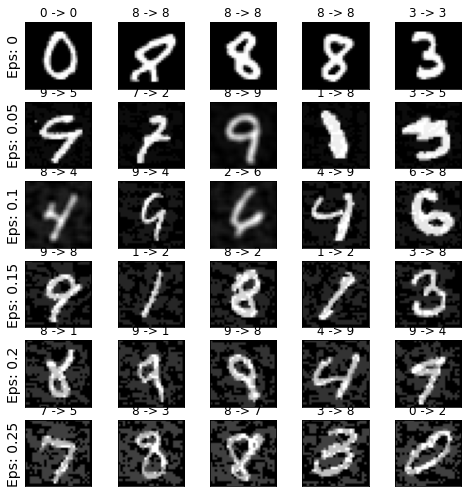

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(Adv_examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(Adv_examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = Adv_examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

IndexError: ignored

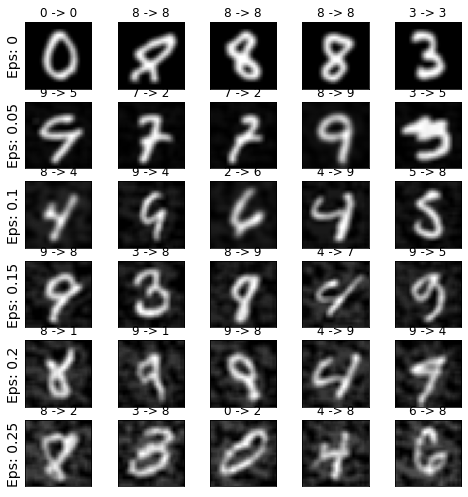

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(Fix_examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(Fix_examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = Fix_examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()